# Training a Neural Network to Classify Spiral Datasets with PyTorch

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable


plt.style.use('classic')
plt.style.use('seaborn')

## Data

### Generate data

In [2]:
N = 100  # num of points per class
D = 2  # data dimension
K = 5  # num of classes, i.e. spirals


# Create "containers" to store training data and test data
# Each row -> a training example
trainX = np.zeros((N* K,D)) 
trainY = np.zeros((N* K, 1))

# Test set of size 1/10 of the training set
test_size = int(N* K/ 5)
testX = np.zeros((test_size, D))
testY = np.zeros((test_size, 1))

c = 2* math.pi* (K-1) / K
for j in range(K):
    ix = range(N* j, N* (j+1))
    
    # Radius
    r = np.linspace(0., 1, N)

    # Angle
    t = np.linspace(j* c, (j + 1)* c, N) + np.random.randn(N)* .2
    
    trainX[ix] = np.c_[r* np.sin(t), r* np.cos(t)]
    trainY[ix] = j

### Generate training and test data

In [3]:
# Shuffle the data for SGD and split training/test set
Z = np.hstack((trainX, trainY))
np.random.shuffle(Z)

# Training set
trainX = Z[:-test_size, :2]
trainY = Z[:-test_size, 2].astype('uint8')
    
# Test set
# Note: we shuffle the data randomly, so the test set is random (may not be uniform)
testX = Z[-test_size:, :2]
testY = Z[-test_size:, 2].astype('uint8')

### Plot training and test data

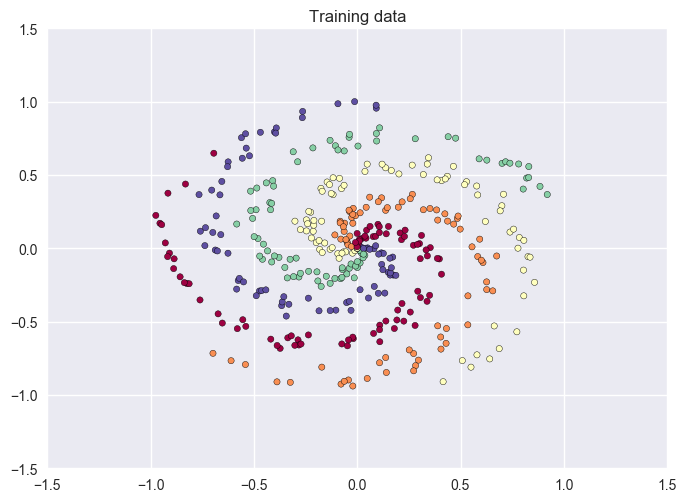

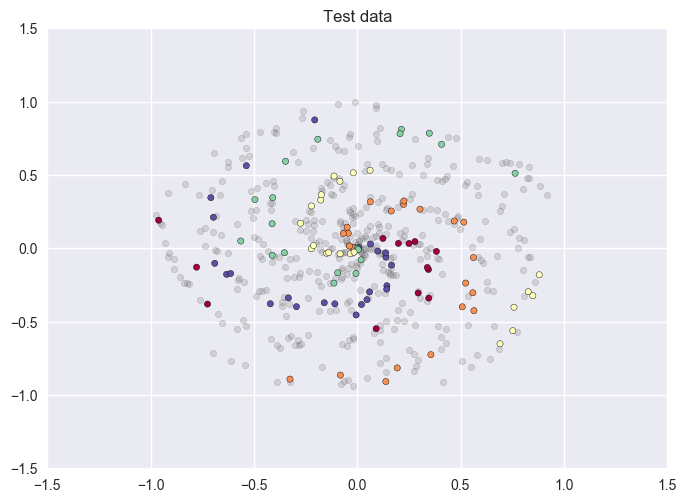

In [4]:
# Plot training set
plt.title('Training data')
plt.scatter(trainX[:, 0], trainX[:, 1], c=trainY, cmap=plt.cm.Spectral)
plt.show()


# Plot test set, use gray dots to denote training data point
plt.title('Test data')
plt.scatter(trainX[:, 0], trainX[:, 1], c='gray', cmap=plt.cm.Spectral, alpha=0.25)
plt.scatter(testX[:, 0], testX[:, 1], c=testY, cmap=plt.cm.Spectral)
plt.show()

## Define Model, Loss Function and Optimizer

In [5]:
# Number of hidden units
H = 100

# Define model
model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, K)
)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e0)

## Training

In [6]:
loss_lst = []

In [7]:
for iteration in range(3000):
    
    # Extract mini-batches from the dataset
    mini_batch = np.random.randint(len(trainX), size=40)  # 1/10 of the dataset as mini-batch
    
    X = Variable(torch.from_numpy(trainX[mini_batch]).type(torch.FloatTensor))
    y = Variable(torch.from_numpy(trainY[mini_batch]).type(torch.LongTensor))
    
    
    # Forward pass and loss compute
    pred = model.forward(X)
    loss = loss_fn(pred, y)
    
    loss_lst.append(loss.data[0])

    # Backward pass and parameter update
    optim.zero_grad()
    loss.backward(retain_variables=True)
    optim.step()

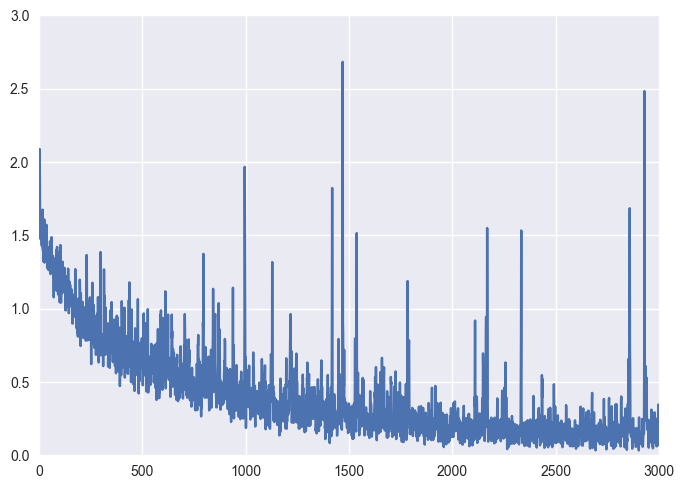

In [8]:
plt.plot(loss_lst)
plt.show()

## Evaluate Training Accuracy and Plot Decision Boundary

In [9]:
def evaluate_and_plot(X, Y, model, evaluate=True, plot=True):
    """
    X, Y: torch Variables
    model: torch model
    """
    
    if evaluate:
        
        # Compute output
        pred = model.forward(X).data.numpy()

        # Compute training accuracy
        pred = pred.argmax(axis=1)
        accu = np.mean(pred == Y.data.numpy()).round(2)
        print('Accuracy: {0}'.format(accu))
        
        
    if plot:
        
        # Plot the resulting classifier with training data
        h = 0.01

        # Pick boundaries of x and y
        X = X.data.numpy()
        Y = Y.data.numpy()
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        points = \
            Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor))
        
        # Forward pass to compute output
        Z = model.forward(points).data.numpy()
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())

        plt.show()

Accuracy: 0.95


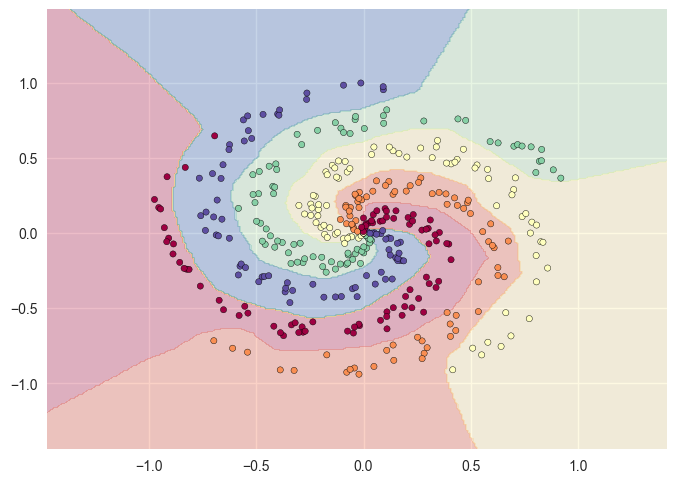

In [10]:
_trainX = Variable(torch.from_numpy(trainX).type(torch.FloatTensor))
_trainY = Variable(torch.from_numpy(trainY).type(torch.FloatTensor))

# Evaluate on training set
evaluate_and_plot(_trainX, _trainY, model)

## Evaluate Test Accuracy 

Accuracy: 0.9


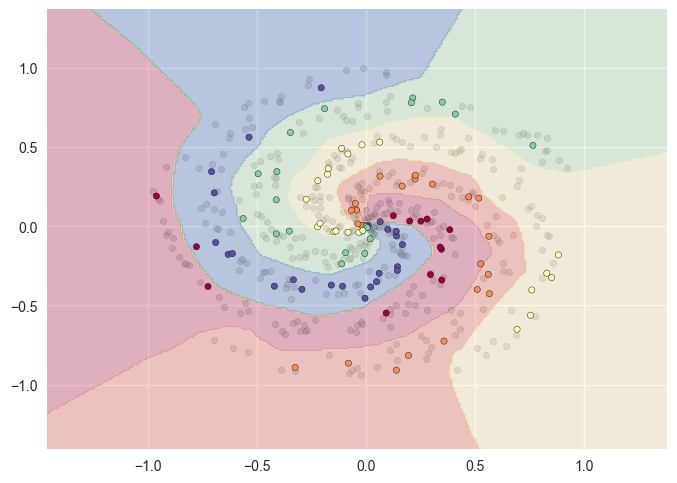

In [11]:
# Evaluate on test set
plt.scatter(trainX[:, 0], trainX[:, 1], c='gray', cmap=plt.cm.Spectral, alpha=0.25)


_testX = Variable(torch.from_numpy(testX).type(torch.FloatTensor))
_testY = Variable(torch.from_numpy(testY).type(torch.FloatTensor))

# Evaluate on test set
evaluate_and_plot(_testX, _testY, model)